In [1]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
arch = {'knl':(cm.Greens, 450,0.5,0.33),'skl':(cm.Greys,200,0.5,0.75),   'p100':(cm.Blues,  550,0.5,0.43),
       'v100':(cm.Purples,850,0.5,0.85), 'i5':(cm.Wistia,30,0.5,0.79),'gtx1060':(cm.Oranges,155,0.5,0.70)}
intens={1:0.8, 2:0.6, 4:0.4}
marker={2:'d', 3:'o', 4:'s',5:'p'}
#(hardware name, number of nodes)
filesD = {
        'knl_mpi1':('knl',1),
        'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
        'skl_mpi1':('skl',1), 
        'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
        'i5':('i5',1),
        'p100_mpi1':('p100',1), 
        'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
        'v100_mpi1':('v100',1), 
        'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
        'gtx1060':('gtx1060',1)
        }

files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1
pd.set_option('precision',2)

In [3]:
#(axpby,dot,dxdy)
latencies = odict()
latencies['scal'] = (1,0,0)
latencies['axpby'] = (1,0,0)
latencies['pointwiseDot'] = (1,0,0)
latencies['dot'] = (0,1,0)
latencies['dx'] = (0,0,1)
latencies['dy'] = (0,0,1)
latencies['arakawa'] = (3,0,6)
latencies['cg'] = (6,2,6)
memops = odict()
memops['scal']= (2,0,0)
memops['axpby']= (3,0,0)
memops['pointwiseDot']= (6,0,0)
memops['dot']= (0,2,0)
memops['dx']= (0,0,3)
memops['dy']= (0,0,3)
memops['arakawa'] = (16,0,18) # two aliases in pointwiseDot
memops['cg'] = (20,4,18)

In [4]:
theo = pd.read_csv('performance.csv',delimiter=' ')
theo.set_index('arch',inplace=True)
theo.index.name = None

theo

,axpby_bw,dot_bw,dxdy2_bw,dxdy3_bw,dxdy4_bw,dxdy5_bw,axpby_lat_shared,axpby_lat_dist,dot_lat_shared,dot_lat_dist,dxdy_lat_shared,dxdy_lat_dist
i5,29.99,0.31,0.93,0.97,0.85,0.72,0.00,NaN,4.76,NaN,0.00,NaN
skl,206.71,0.93,0.88,0.78,0.57,0.54,0.00,0.00,17.28,37.93,22.70,28.52
knl,393.15,0.36,0.61,0.44,0.32,0.26,5.47,9.16,54.83,119.59,9.93,52.67
gtx1060,157.05,0.17,0.83,0.71,0.53,0.44,0.00,NaN,92.06,NaN,0.00,NaN
p100,553.33,0.63,0.52,0.43,0.36,0.30,0.23,2.42,48.15,48.16,1.82,63.51
v100,848.36,0.70,0.95,0.84,0.77,0.63,1.22,2.30,33.95,34.73,3.11,66.63


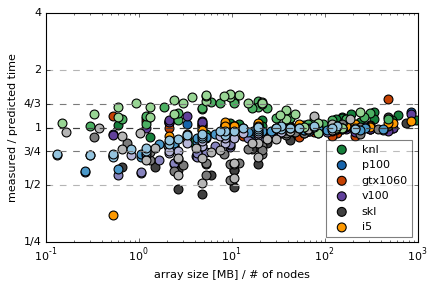

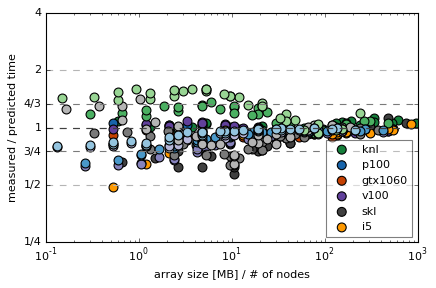

In [5]:
#now compute and plot the prediction 
for n in ['arakawa','cg'] :#latencies.keys():
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 80, facecolor='w', edgecolor='k')
    xs = np.array([0.1,1000])
    ys = np.array([1.0,1.0])
    for frac in [1.0,4/3,8/4]:
        plt.plot(xs,frac*ys,ls='--',color=cm.Greys(0.8/frac))
        plt.plot(xs,1/frac*ys,ls='--',color=cm.Greys(0.8/frac))
        
    for f, v in files.items() :#{'knl_mpi2':('knl',2)}.items():

        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        dfr = df[['n','Nx','Ny','size']+list(memops.keys())]
        #compute mean and standard derivation of 'same' groups 
        dfr=dfr.groupby(['n', 'Nx','Ny','size']).mean()
        dfr=dfr.reset_index(level=['n','Nx','Ny','size'])

        dfr['FirstLevel']='measured'
        dfr.columns=pd.MultiIndex.from_product([dfr.columns,['measured']])
        del dfr['FirstLevel']
        
        dfr['dxdy_bw'] = dfr.apply( 
            lambda row: theo.loc[v[0],'dxdy'+str(row['n','measured'].astype(int))+'_bw'], axis=1)

        dxdystring = 'dxdy_lat_shared'
        dotstring = 'dot_lat_shared'
        if v[1] > 1 : 
            dxdystring = 'dxdy_lat_dist'
            dotstrint = 'dot_lat_dist'
        for q,l in latencies.items():
            m = memops[q]
            dfr.loc[:,(q,'predicted')] = (
                                    ( l[0]*theo.loc[v[0],'axpby_lat_shared']+
                                      l[1]*theo.loc[v[0],dotstring] +
                                      l[2]*theo.loc[v[0],dxdystring]
                                    )*1e-6+
                                    (m[0] + m[1]/theo.loc[v[0],'dot_bw'] + m[2]/dfr['dxdy_bw',''])
                                       *dfr[('size','measured')]/1000/theo.loc[v[0],'axpby_bw'])
            dfr.loc[:,(q,'meas/pred')]=dfr[(q,'measured')]/dfr[(q,'predicted')]

        toPlot = dfr[n].join(dfr[('size')],rsuffix='_size')
        toPlot.plot(kind='scatter',ax=ax,color=arch[v[0]][0](intens[v[1]]),edgecolors='k',
                     x=('measured_size'), y='meas/pred',label=v[0],s=64)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:number]; labels = labels[0:number]

    #plt.plot(xs,ys)

    
    plt.legend(handles, labels, loc='lower right',
               scatterpoints=1,fontsize='medium',framealpha=0.5)
    plt.xscale('log')
    plt.xlim(xs[0],xs[1])
    #plt.xlabel('measured time in s')
    plt.xlabel('array size [MB] / # of nodes')
    plt.ylabel('measured / predicted time')
    plt.yscale('log', subsy=[0])#log scale, turn minor ticks off
    plt.ylim(1/3,3)
    plt.yticks([1/4,0.5,0.75,1,1.33,2,4],['1/4','1/2','3/4',1,'4/3',2,4])
    #plt.title(n)
    plt.savefig(n+'.pdf',bbox_inches='tight')

### Observations
- plots show deviations from the predicted timing
- the goal of the discussion is to prove that the time formula is correct because then performance can be discussed analytically and makes "scaling" plots somewhat obsolete
- there seems to be a systematic overestimation of the knl MPI scaling (is this the fault of the implemenation? What is wrong there?)
- the 2 node MPI scaling is off for small sizes because only one direction is parallelized and so latency is overestimated. On KNL we only parallelize x - direction so we don't see this there.
- skl and i5 for small sizes are mostly faster than predicted because cache effects are not included in the model
- there seems to a drop in efficiency in GPUs when the problem size nears the full size of the GPU memory (last single node points in GTX, P100 and V100)